In [37]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tqdm is a library in Python that provides a fast, extensible progress bar for
# loops and other iterable processes. When you use from tqdm import tqdm,
# you are importing the tqdm class, which you can then use to wrap an iterable
# and create a progress bar for it. This can be particularly useful when you have
# long-running tasks or loops, as it gives you a visual indication of the progres
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [38]:
# Download dataset
path = kagglehub.dataset_download("catherinehorng/dogbreedidfromcomp")

In [39]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv(path+'/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [40]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [41]:
# Selecting random 50  breeds (Limitation due to computation power)
CLASS_NAMES =  labels_all['breed'].unique()
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels

,index,id,breed
0,0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,2,001cdf01b096e06d78e9e5112d419397,pekinese
3,3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...,...
10217,10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [42]:
# Write all selected breeds
labels['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [43]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):

    # target_size=(224, 224): resizes the image to a standard size of 224x224 pixels.
    # %s for keep 'labels['id'][i]' as string format
    # For example  labels['id'][i] holds the value '00123', the resulting path becomes:
    #         'dog_dataset/train/00123.jpg'
    img = image.load_img(path + '/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)

    x = np.expand_dims(img.copy(), axis=0)
    # Normalizing pixel values  to avoid the possibility of exploding gradients
    # because of the high range of the pixels [0, 255], and improve the convergence speed.
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 10222/10222 [00:08<00:00, 1184.87it/s]


Train Images shape:  (10222, 224, 224, 3)  size: 1,538,697,216
One-hot encoded output shape:  (10222, 120)  size: 1,226,640


In [44]:
Y_data = label_binarize(labels['breed'], classes = list(labels['breed'].unique()))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

One-hot encoded output shape:  (10222, 120)  size: 1,226,640


In [45]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [46]:
from keras.applications import MobileNetV2
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load pre-trained MobileNetV2 model
# include_top: whether to include the 3 fully-connected layers at the top of the network.
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=True, 
    input_shape=(224, 224, 3), 
    pooling='max',
    classifier_activation="softmax"
)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the MobileNetV2 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(724, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(Y_data.shape[1], activation='softmax'))  # Adjust the number of classes based on your dataset

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1000)           │     3,538,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 724)            │       724,724 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       371,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 120)            │         7,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,880,980 (18.62 MB)

 Trainable params: 1,341,996 (5.12 MB)

 Non-trainable params: 3,538,984 (13.50 MB)

In [48]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 374ms/step - accuracy: 0.7688 - loss: 1.0913 - val_accuracy: 0.7473 - val_loss: 1.2551
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - accuracy: 0.7599 - loss: 1.0697 - val_accuracy: 0.7473 - val_loss: 1.2343
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.7754 - loss: 1.0279 - val_accuracy: 0.7543 - val_loss: 1.2172
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 388ms/step - accuracy: 0.7851 - loss: 0.9775 - val_accuracy: 0.7495 - val_loss: 1.2181
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 340ms/step - accuracy: 0.7729 - loss: 0.9807 - val_accuracy: 0.7505 - val_loss: 1.1990
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 342ms/step - accuracy: 0.7919 - loss: 0.9020 - val_accuracy: 0.7549 - val_loss: 1.1879
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 343ms/step - accuracy: 0.7832 - loss: 0.9400 - val_accuracy: 0.7549 - val_loss: 1.1982
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.7887 - loss: 0

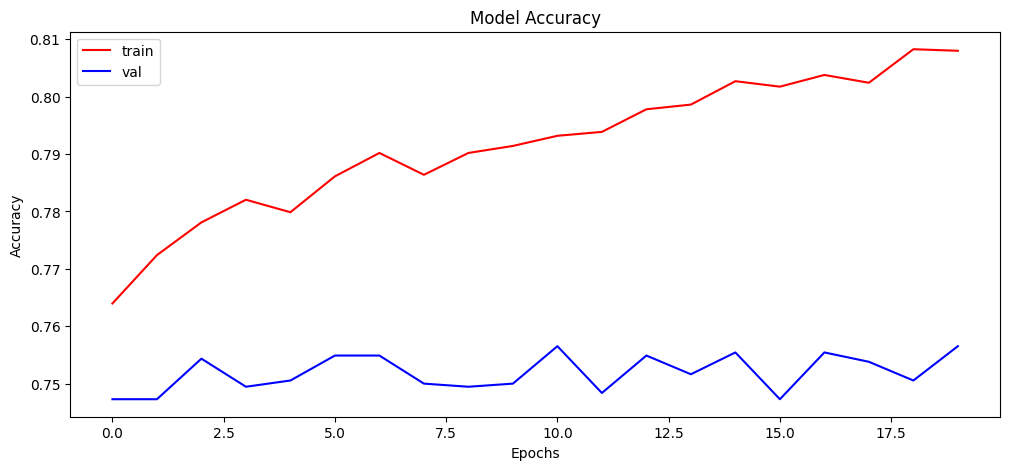

In [49]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [50]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7559 - loss: 1.1696
Accuracy over the test set: 
  75.17 %


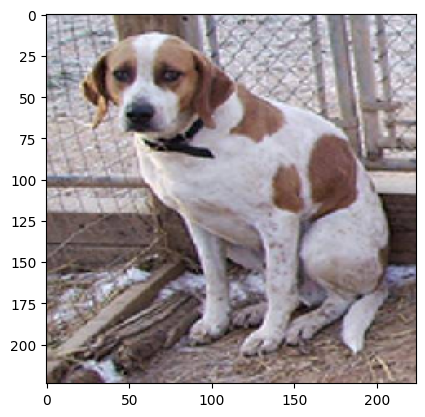

Originally :  shetland_sheepdog
Predicted :  shetland_sheepdog


In [51]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [53]:
model.save("dog_breed.h5")